In [2]:
%load_ext lab_black

In [3]:
import sys

sys.path.append("..")
from gpjax import Prior, RBF, Gaussian, ZeroMean
import jax
import jax.numpy as jnp
import jax.random as jr
import objax
import numpy as onp
import matplotlib.pyplot as plt

key = jr.PRNGKey(123)

# Synthetic datasets

With necessary libraries and modules imported we can simulate some data. We'll sample our inputs $x$ according to $x_1, \ldots , x_{50} \overset{iid}{\sim} \mathcal{U}(-3., 3)$ and corresponding outputs will be $y_i = \sin(4x_i) + \cos(2 x_i) + \epsilon_i$ such that $\epsilon_i \sim \mathcal{N}(0, 0.1)$. 

In [4]:
N = 50
noise = 0.1

X = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(N,)).sort().reshape(-1, 1)
# X = X.sort()
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(X)
y = signal + jr.normal(key, shape=signal.shape) * noise
Xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(Xtest)

To better understand the data that we have simulated, we can plot both the underlying function along with the observations that we have assumed to be perturbed by some isotropic Gaussian noise.

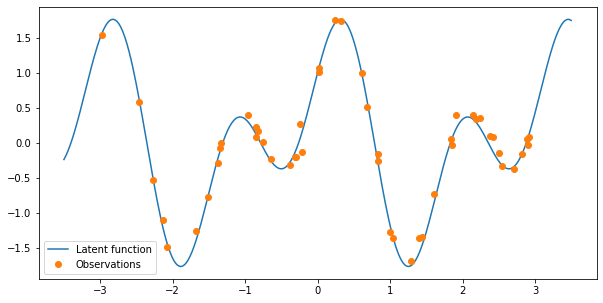

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(Xtest, ytest, label="Latent function")
ax.plot(X, y, "o", label="Observations")
ax.legend(loc="best")
# plt.savefig("data.png")

# Define GP prior

We can now set about defining our model. A zero-mean Gaussian process places a prior over $f$ such that $p(f) \sim \mathcal{N}(0, K_{xx})$ where $K_{xx}$ is the Gram matrix that is generated by a user-specified kernel function $k$ such that $[K_{xx}]_{i, j} = k(x_i, x_j)$. The choice of kernel function is an important choice as, among other things, it governs the smoothness of the outputs that our Gaussian process model can generate. For now, we'll use a squared exponential kernel which takes the form 
$$k(x, x') = \sigma^2 \exp\left(-\frac{\lVert x-x' \rVert_2^2}{2 \ell^2}\right).$$
As we can see, the squared exponential kernel has two parameters; a lengthscale $\ell$ that controls horizontal displacement, and a variance term $\sigma$ that controls vertical displacement. We'll initialise both these terms at 1.

In [17]:
kernel = RBF(lengthscale=jnp.array([1.0]), variance=jnp.array([1.0]))
meanf = ZeroMean()

prior = Prior(kernel=kernel, mean_function=meanf, jitter=1e-6)

Add some prior sampling code here.

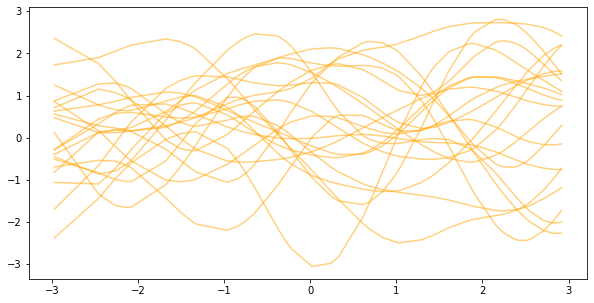

In [18]:
samples = prior.sample(X, key, n_samples=20)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, samples.T, color="orange", alpha=0.5)
# plt.savefig("prior_samples.png")

A Gaussian process is a form of Bayesian model. Therefore, our object of interest is the posterior distribution, and to get to this we must combine our prior beliefs with our assumptions about the source of the data. We state the latter of these assumptions through a likelihood term which, for now, we assume to be Gaussian. 

In [19]:
likelihood = Gaussian()
posterior = prior * likelihood

# Optimise the posterior

The likelihood here is Gaussian, therefore we are able to analytically integrate out the latent function from our posterior. Because of this, all that is left to do is optimise the GP's hyperparameters $\mathbf{\theta}$ which, for this kernel type, comprises of a kernel lengthscale and variance parameter, along with an observation noise term.

To proceed, we first define an objective function for which an optimiser can minimise.

In [20]:
opt = objax.optimizer.SGD(posterior.vars())

For the optimiser to work, gradients of the GP's marginal log-likelihood (MLL) are required. The `Posterior` object has a convenient method `.neg_mll` that allows us to access the negation of this quantity. Using the automatic differentiation that is built into Jax, we can then define the gradient of our negative MLL term with respect to $\theta$ in order to minimise it. Minimising the negative MLL is equivalent to maximising the MLL, which is implicitly what we want to do.

In [21]:
gv = objax.GradValues(posterior.neg_mll, posterior.vars())

Let's wrap this up now into a optimisation step. This may seem superfluous, but doing so will allow us to them compile the function. Long-term, a compiled function will operate more efficiently than a regular function. 

In [22]:
def train_op(x, label):
    g, v = gv(x, label)
    opt(0.01, g)
    return v


train_op = objax.Jit(train_op, gv.vars() + opt.vars())

Everything is now in place to begin optimise the GP's hyperparameters.

In [23]:
nits = 100
loss = [train_op(X, y.squeeze())[0].item() for _ in range(nits)]

Text(0.5, 0, 'Optimsation step number')

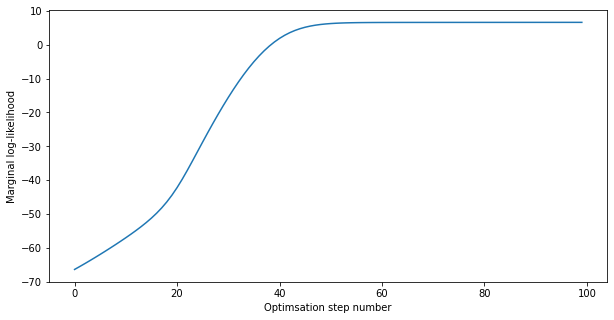

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot([-l for l in loss])
ax.set_ylabel("Marginal log-likelihood")
ax.set_xlabel("Optimsation step number")
# plt.savefig("optimisation.png")

# Predict

We can now begin to make predictions at some unseen test points $X^{\star}$. To do this, we sample from the GP's predictive posterior 

In [25]:
mu, cov = posterior.predict(Xtest, X, y.squeeze())

Now let's visualise this 

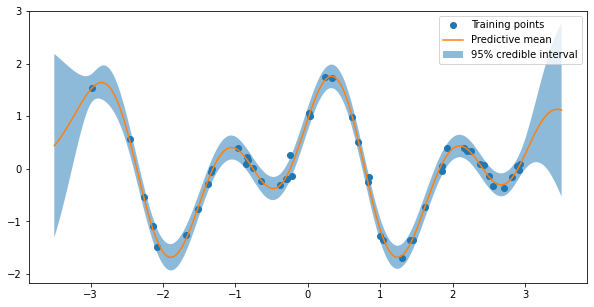

In [26]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(X, y, "o", label="Training points")
ax.plot(Xtest, mu, label="Predictive mean")
ax.fill_between(
    Xtest.ravel(),
    mu.squeeze()
    - 1.96
    * jnp.sqrt(jnp.diag(cov) + jax.nn.softplus(posterior.likelihood.noise.value)),
    mu.squeeze()
    + 1.96
    * jnp.sqrt(jnp.diag(cov) + jax.nn.softplus(posterior.likelihood.noise.value)),
    alpha=0.5,
    label="95% credible interval",
)
ax.legend(loc="best")
# plt.savefig("predictive_posterior.png")